## Step 0: Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. 

## Step 1: Load the dataset

The dataset we'll use is a list of over one million news headlines published over a period of 15 years. We'll start by loading it from the `abcnews-date-text.csv` file.

In [1]:
'''
Load the dataset from the CSV and save it to 'data_text'
'''
import pandas as pd
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);
# We only need the Headlines text column from the data
data_text = data[:300000][['headline_text']];
data_text['index'] = data_text.index

documents = data_text

Let's glance at the dataset:

In [2]:
'''
Get the total number of documents
'''
print(len(documents))

300000


In [3]:
documents[:5]

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


## Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [6]:
'''
Loading Gensim and nltk libraries
'''
#!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rababalkhalifa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [8]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [9]:
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [10]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            # TODO: Apply lemmatize_stemming() on the token, then add to the results list
            result.append(lemmatize_stemming(token))
            
    return result



In [11]:
'''
Preview a document after preprocessing
'''
document_num = 4310
doc_sample = documents[documents['index'] == document_num].values[0][0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['rain', 'helps', 'dampen', 'bushfires']


Tokenized and lemmatized document: 
['rain', 'help', 'dampen', 'bushfir']


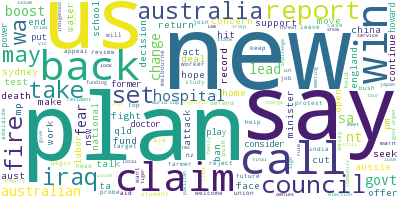

In [64]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents['headline_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

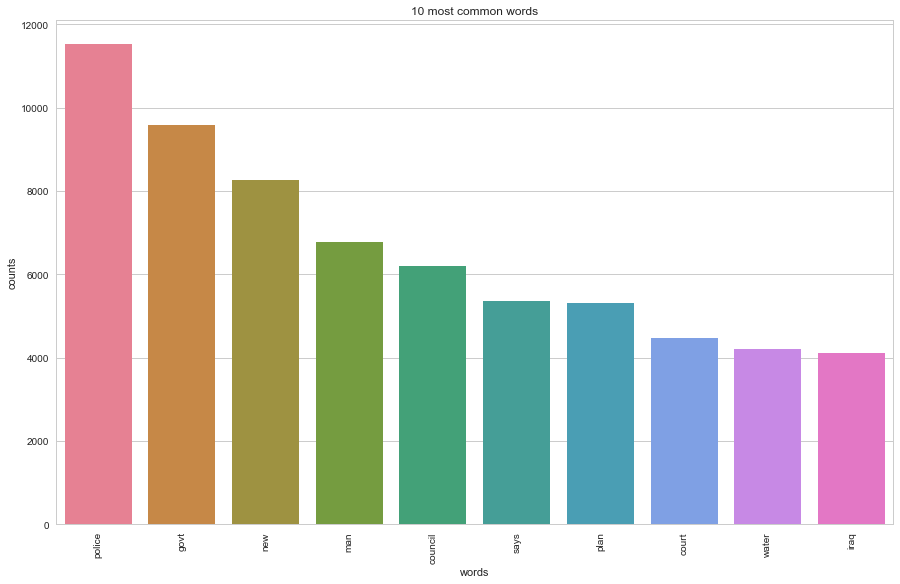

In [68]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(documents['headline_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Let's now preprocess all the news headlines we have. To do that, let's use the [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function from pandas to apply `preprocess()` to the `headline_text` column

**Note**: This may take a few minutes (it take 6 minutes on my laptop)

In [15]:
# TODO: preprocess all the headlines, saving the list of results as 'processed_docs'
import time

start = time.time()

# run your code
processed_docs = []
for headline in documents.headline_text:
    processed_docs.append(preprocess (headline))
end = time.time()

elapsed_time = end - start

time.strftime("%H:%M:%S", time.gmtime(elapsed_time))    

'00:01:18'

In [16]:
'''
Preview 'processed_docs'
'''
processed_docs[:10]

[['decid', 'communiti', 'broadcast', 'licenc'],
 ['wit', 'awar', 'defam'],
 ['call', 'infrastructur', 'protect', 'summit'],
 ['staff', 'aust', 'strike', 'rise'],
 ['strike', 'affect', 'australian', 'travel'],
 ['ambiti', 'olsson', 'win', 'tripl', 'jump'],
 ['antic', 'delight', 'record', 'break', 'barca'],
 ['aussi', 'qualifi', 'stosur', 'wast', 'memphi', 'match'],
 ['aust', 'address', 'secur', 'council', 'iraq'],
 ['australia', 'lock', 'timet']]

## Step 3.1: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [17]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [18]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 communiti
2 decid
3 licenc
4 awar
5 defam
6 wit
7 call
8 infrastructur
9 protect
10 summit


** Gensim filter_extremes **

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Filter out tokens that appear in

* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [21]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
# TODO: apply dictionary.filter_extremes() with the parameters mentioned above
dictionary.filter_extremes(no_below=15, no_above=0.10, keep_n=100000)

** Gensim doc2bow **

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [32]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
# TODO
bow_corpus = []
for doc in processed_docs:
    bow_corpus.append(dictionary.doc2bow(doc))

In [35]:
bow_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1), (13, 1), (14, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1)],
 [(18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
 [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(11, 1), (32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1)],
 [(34, 1), (36, 1), (39, 1), (40, 1)],
 [(22, 1), (25, 1), (41, 1), (42, 1), (43, 1)],
 [(44, 1), (45, 1)],
 [(46, 1), (47, 1), (48, 1), (49, 1)],
 [(45, 1), (50, 1), (51, 1), (52, 1)],
 [(53, 1), (54, 1), (55, 1), (56, 1)],
 [(57, 1), (58, 1), (59, 1), (60, 1)],
 [(60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)],
 [(66, 1), (67, 1), (68, 1), (69, 1), (70, 1)],
 [(71, 1), (72, 1), (73, 1), (74, 1)],
 [(75, 1), (76, 1), (77, 1), (78, 1)],
 [(79, 1), (80, 1), (81, 1), (82, 1)],
 [(44, 1), (83, 1), (84, 1), (85, 1)],
 [(86, 1), (87, 1), (88, 1), (89, 1), (90, 1)],
 [(91, 1), (92, 1), (93, 1)],
 [(94, 1

In [33]:
'''
Checking Bag of Words corpus for our sample document --> (token_id, token_count)
'''
bow_corpus[document_num]

[(71, 1), (107, 1), (462, 1), (3530, 1)]

In [34]:
'''
Preview BOW for our sample preprocessed document
'''
# Here document_num is document number 4310 which we have checked in Step 2
bow_doc_4310 = bow_corpus[document_num]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 71 ("bushfir") appears 1 time.
Word 107 ("help") appears 1 time.
Word 462 ("rain") appears 1 time.
Word 3530 ("dampen") appears 1 time.


## Step 3.2: TF-IDF on our document set ##

While performing TF-IDF on the corpus is not necessary for LDA implemention using the gensim model, it is recemmended. TF-IDF expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality.

*Please note: The author of Gensim dictates the standard procedure for LDA to be using the Bag of Words model.*

** TF-IDF stands for "Term Frequency, Inverse Document Frequency".**

* It is a way to score the importance of words (or "terms") in a document based on how frequently they appear across multiple documents.
* If a word appears frequently in a document, it's important. Give the word a high score. But if a word appears in many documents, it's not a unique identifier. Give the word a low score.
* Therefore, common words like "the" and "for", which appear in many documents, will be scaled down. Words that appear frequently in a single document will be scaled up.

In other words:

* TF(w) = `(Number of times term w appears in a document) / (Total number of terms in the document)`.
* IDF(w) = `log_e(Total number of documents / Number of documents with term w in it)`.

** For example **

* Consider a document containing `100` words wherein the word 'tiger' appears 3 times. 
* The term frequency (i.e., tf) for 'tiger' is then: 
    - `TF = (3 / 100) = 0.03`. 

* Now, assume we have `10 million` documents and the word 'tiger' appears in `1000` of these. Then, the inverse document frequency (i.e., idf) is calculated as:
    - `IDF = log(10,000,000 / 1,000) = 4`. 

* Thus, the Tf-idf weight is the product of these quantities: 
    - `TF-IDF = 0.03 * 4 = 0.12`.

In [36]:
'''
Create tf-idf model object using models.TfidfModel on 'bow_corpus' and save it to 'tfidf'
'''
from gensim import corpora, models

# TODO
tfidf = models.TfidfModel(bow_corpus)

In [49]:
'''
Apply transformation to the entire corpus and call it 'corpus_tfidf'
'''
# # TODO

corpus_tfidf= tfidf[bow_corpus]

In [50]:
'''
Preview TF-IDF scores for our first document --> --> (token_id, tfidf score)
'''
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5959813347777092),
 (1, 0.39204529549491984),
 (2, 0.48531419274988147),
 (3, 0.50554610985785686)]


## Step 4.1: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

** We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.
* **alpha** and **eta** are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is `1/num_topics`)
    - Alpha is the per document topic distribution.
        * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
        * Low alpha: Every document has a mixture of very few topics

    - Eta is the per topic word distribution.
        * High eta: Each topic has a mixture of most words(topics appear similar to each other).
        * Low eta: Each topic has a mixture of few words.

* ** passes ** is the number of training passes through the corpus. For  example, if the training corpus has 50,000 documents, chunksize is  10,000, passes is 2, then online training is done in 10 updates: 
    * `#1 documents 0-9,999 `
    * `#2 documents 10,000-19,999 `
    * `#3 documents 20,000-29,999 `
    * `#4 documents 30,000-39,999 `
    * `#5 documents 40,000-49,999 `
    * `#6 documents 0-9,999 `
    * `#7 documents 10,000-19,999 `
    * `#8 documents 20,000-29,999 `
    * `#9 documents 30,000-39,999 `
    * `#10 documents 40,000-49,999` 

In [105]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
number_topics = 10
# TODO
lda_model = gensim.models.LdaModel(bow_corpus, 
                                   num_topics = number_topics, 
                                   id2word = dictionary,                                    
                                   passes = 2)

In [107]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      11.913110        1       1 -0.231838  0.010885
2      10.903850        1       2 -0.220310  0.060456
4      10.795267        1       3  0.216034  0.160355
0       9.864489        1       4  0.194066  0.303727
5       9.823441        1       5 -0.067835  0.025051
7       9.738648        1       6 -0.234303  0.091924
9       9.519806        1       7  0.022146 -0.134882
1       9.330290        1       8  0.080109 -0.219090
8       9.058184        1       9  0.100737 -0.201921
3       9.052916        1      10  0.141195 -0.096505, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
223   Default  12266.000000      polic  12266.000000  30.0000  30.0000
45    Default   8532.000000       plan   8532.000000  29.0000  29.0000
52    Default   7735.000000      water   7735.000000  28.0000  28.0000
153   Default  11955.000000       govt  11955.000000  27.0000  27.0000
506   Default   4916.000000       kill   4916.000000  26.0000  26.0000
405   Default   4351.000000       face   4351.000000  25.0000  25.0000
301   Default   5329.000000      charg   5329.000000  24.0000  24.0000
200   Default   4644.000000      court   4644.000000  23.0000  23.0000
33    Default   6891.000000    council   6891.000000  22.0000  22.0000
183   Default   4847.000000      crash   4847.000000  21.0000  21.0000
349   Default   3562.000000      claim   3562.000000  20.0000  20.0000
34    Default   3414.000000       iraq   3414.000000  19.0000  19.0000
93    Default   3286.000000       miss   3286.000000  18.0000  18.0000
176   Default   3350.000000       seek   3350.000000  17.0000  17.0000
259   Default   3406.000000   investig   3406.000000  16.0000  16.0000
309   Default   3189.000000       jail   3189.000000  15.0000  15.0000
265   Default   2960.000000       hous   2960.000000  14.0000  14.0000
1994  Default   2913.000000     sydney   2913.000000  13.0000  13.0000
1941  Default   2955.000000     closer   2955.000000  12.0000  12.0000
199   Default   2925.000000      accus   2925.000000  11.0000  11.0000
7     Default   3097.000000       call   3097.000000  10.0000  10.0000
350   Default   2904.000000     reject   2904.000000   9.0000   9.0000
165   Default   3043.000000      chang   3043.000000   8.0000   8.0000
279   Default   2984.000000       push   2984.000000   7.0000   7.0000
73    Default   6579.000000        urg   6579.000000   6.0000   6.0000
69    Default   2701.000000       lead   2701.000000   5.0000   5.0000
12    Default   2684.000000       rise   2684.000000   4.0000   4.0000
897   Default   2789.000000      labor   2789.000000   3.0000   3.0000
1061  Default   2632.000000      power   2632.000000   2.0000   2.0000
75    Default   3289.000000     attack   3289.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
162   Topic10   2153.483110        die   2154.393129   2.4017  -3.9985
742   Topic10   2027.947967      blaze   2028.857987   2.4016  -4.0585
726   Topic10   1914.513978      fight   1915.433069   2.4016  -4.1161
707   Topic10   1890.247601       take   1891.157635   2.4016  -4.1289
404   Topic10   1825.714713       rule   1826.624744   2.4016  -4.1636
1762  Topic10   1595.786677      train   1596.696717   2.4015  -4.2982
82    Topic10   1527.343765      final   1528.253778   2.4015  -4.3420
181   Topic10   1449.961329  firefight   1450.871335   2.4015  -4.3940
480   Topic10   1408.865077     author   1409.775135   2.4014  -4.4228
856   Topic10   1282.194495      damag   1283.104538   2.4014  -4.5170
370   Topic10   1272.949598   campaign   1273.863908   2.4014  -4.5242
819   Topic10   1264.860369       iran   1265.770434   2.4014  -4.5306
833   Topic10   1222.832805      rescu   1223.742838   2.4013  -4.5644
621   Topic10   1216.244521       caus   12

In [63]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx,topic ))
    print("\n")

Topic: 0 
Words: 0.024*"attack" + 0.024*"continu" + 0.023*"crash" + 0.022*"open" + 0.020*"drought" + 0.018*"farmer" + 0.017*"polic" + 0.016*"record" + 0.016*"driver" + 0.015*"break"


Topic: 1 
Words: 0.029*"call" + 0.025*"nation" + 0.024*"opposit" + 0.021*"meet" + 0.020*"world" + 0.016*"england" + 0.014*"leader" + 0.012*"stand" + 0.012*"river" + 0.012*"target"


Topic: 2 
Words: 0.043*"urg" + 0.025*"govt" + 0.022*"group" + 0.022*"plan" + 0.018*"labor" + 0.015*"worker" + 0.015*"test" + 0.014*"green" + 0.014*"want" + 0.013*"school"


Topic: 3 
Words: 0.036*"polic" + 0.034*"charg" + 0.029*"court" + 0.028*"face" + 0.024*"council" + 0.022*"investig" + 0.021*"chang" + 0.018*"accus" + 0.017*"murder" + 0.017*"drug"


Topic: 4 
Words: 0.032*"kill" + 0.023*"year" + 0.021*"die" + 0.020*"australian" + 0.018*"take" + 0.017*"get" + 0.016*"chief" + 0.014*"offic" + 0.014*"inquiri" + 0.013*"high"


Topic: 5 
Words: 0.030*"iraq" + 0.024*"lead" + 0.020*"say" + 0.019*"howard" + 0.017*"rise" + 0.017*"repo

### Classification of the topics ###

Using the words in each topic and their corresponding weights, what categories were you able to infer?

* 0: crime
* 1: international news
* 2: education 
* 3: crime
* 4: crime
* 5: crime
* 6: crime
* 7: acciedents
* 8: international news
* 9: acciedents

## Step 4.2 Running LDA using TF-IDF ##

In [69]:
'''
Define lda model using corpus_tfidf, again using gensim.models.LdaMulticore()
'''
# TODO
lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 2)

In [108]:
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      10.984043        1       1  0.162509  0.037481
4      10.551788        1       2  0.158450  0.089986
0      10.400154        1       3 -0.022448  0.164971
6      10.209421        1       4 -0.355891 -0.011890
2      10.003064        1       5 -0.040377  0.103684
1       9.881214        1       6 -0.019516 -0.286619
5       9.705121        1       7 -0.038835 -0.072308
9       9.609782        1       8 -0.045772  0.191214
7       9.374639        1       9  0.142679 -0.042203
8       9.280774        1      10  0.059200 -0.174317, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
1941  Default  2591.000000      closer  2591.000000  30.0000  30.0000
259   Default  1327.000000    investig  1327.000000  29.0000  29.0000
93    Default  1242.000000        miss  1242.000000  28.0000  28.0000
301   Default  1889.000000       charg  1889.000000  27.0000  27.0000
373   Default  1090.000000     drought  1090.000000  26.0000  26.0000
284   Default  1051.000000      murder  1051.000000  25.0000  25.0000
183   Default  1787.000000       crash  1787.000000  24.0000  24.0000
2075  Default   903.000000        rudd   903.000000  23.0000  23.0000
897   Default  1142.000000       labor  1142.000000  22.0000  22.0000
200   Default  1520.000000       court  1520.000000  21.0000  21.0000
729   Default   938.000000       elect   938.000000  20.0000  20.0000
499   Default   924.000000      search   924.000000  19.0000  19.0000
742   Default   872.000000       blaze   872.000000  18.0000  18.0000
2316  Default   867.000000        hick   867.000000  17.0000  17.0000
162   Default   997.000000         die   997.000000  16.0000  16.0000
770   Default   807.000000       price   807.000000  15.0000  15.0000
395   Default  1122.000000     opposit  1122.000000  14.0000  14.0000
537   Default   800.000000     nuclear   800.000000  13.0000  13.0000
60    Default   801.000000       troop   801.000000  12.0000  12.0000
1437  Default   791.000000     assault   791.000000  11.0000  11.0000
546   Default   788.000000        teen   788.000000  10.0000  10.0000
435   Default   738.000000       feder   738.000000   9.0000   9.0000
425   Default   945.000000      farmer   945.000000   8.0000   8.0000
350   Default  1104.000000      reject  1104.000000   7.0000   7.0000
323   Default   715.000000       mayor   715.000000   6.0000   6.0000
181   Default   680.000000   firefight   680.000000   5.0000   5.0000
1142  Default   907.000000       resid   907.000000   4.0000   4.0000
268   Default   871.000000      arrest   871.000000   3.0000   3.0000
23    Default   824.000000       break   824.000000   2.0000   2.0000
199   Default  1106.000000       accus  1106.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
456   Topic10   499.994791     control   500.913865   2.3754  -4.7227
192   Topic10   481.683952     violenc   482.603026   2.3753  -4.7600
106   Topic10   469.518763         rat   470.437834   2.3753  -4.7856
935   Topic10   450.600502        link   451.519610   2.3752  -4.8267
423   Topic10   442.902831      second   443.821947   2.3752  -4.8439
120   Topic10   435.260702        move   436.179792   2.3751  -4.8614
2440  Topic10   430.813741     baghdad   431.732835   2.3751  -4.8716
299   Topic10   421.979603     central   422.898681   2.3750  -4.8923
869   Topic10   405.733488       refus   406.652575   2.3750  -4.9316
213   Topic10   402.359754     project   403.278833   2.3749  -4.9399
715   Topic10   394.097634       grant   395.016717   2.3749  -4.9607
217   Topic10   390.711539      impact   391.630612   2.3749  -4.9693
188   Topic10   386.452362      profit   387.371420   2.3748  -4.9803
2473  Topic10   382.034127  indonesian   382.953203   2.3748  -4.9918
868   Topic10   374

In [70]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.021*"investig" + 0.020*"miss" + 0.017*"crash" + 0.017*"polic" + 0.015*"elect" + 0.015*"search" + 0.014*"hick" + 0.011*"mayor" + 0.011*"timor" + 0.010*"bodi"


Topic: 1 Word: 0.013*"troop" + 0.012*"break" + 0.010*"iraq" + 0.010*"prompt" + 0.009*"rise" + 0.008*"black" + 0.008*"toll" + 0.008*"rate" + 0.008*"increas" + 0.008*"australian"


Topic: 2 Word: 0.012*"reject" + 0.011*"climat" + 0.010*"shoot" + 0.009*"damag" + 0.009*"tiger" + 0.009*"gold" + 0.009*"solomon" + 0.008*"indigen" + 0.008*"drive" + 0.008*"stay"


Topic: 3 Word: 0.016*"drought" + 0.014*"water" + 0.011*"farmer" + 0.010*"help" + 0.009*"storm" + 0.009*"govt" + 0.009*"push" + 0.009*"group" + 0.008*"plan" + 0.007*"doctor"


Topic: 4 Word: 0.016*"labor" + 0.013*"govt" + 0.012*"resid" + 0.012*"health" + 0.012*"feder" + 0.009*"servic" + 0.009*"liber" + 0.009*"fund" + 0.008*"school" + 0.008*"test"


Topic: 5 Word: 0.015*"die" + 0.014*"nuclear" + 0.013*"kill" + 0.011*"green" + 0.010*"north" + 0.010*"injur" + 0.010*

### Classification of the topics ###

As we can see, when using tf-idf, heavier weights are given to words that are not as frequent which results in nouns being factored in. That makes it harder to figure out the categories as nouns can be hard to categorize. This goes to show that the models we apply depend on the type of corpus of text we are dealing with. 

Using the words in each topic and their corresponding weights, what categories could you find?

* 0: crime - investigation
* 1: international news - war 
* 2: sea and water
* 3: agriculture
* 4: work and education
* 5: international news - nuclear
* 6: crime - murder
* 7: accedint - fire
* 8: sea and water
* 9: work and education

## Step 5.1: Performance evaluation by classifying sample document using LDA Bag of Words model##

We will check to see where our test document would be classified. 

In [71]:
'''
Text of sample document 4310
'''
processed_docs[4310]

['rain', 'help', 'dampen', 'bushfir']

In [72]:
'''
Check which topic our test document belongs to using the LDA Bag of Words model.
'''
document_num = 4310
# Our test document is document number 4310

# TODO
# Our test document is document number 4310
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.42048969864845276	 
Topic: 0.032*"kill" + 0.023*"year" + 0.021*"die" + 0.020*"australian" + 0.018*"take" + 0.017*"get" + 0.016*"chief" + 0.014*"offic" + 0.014*"inquiri" + 0.013*"high"

Score: 0.4194732904434204	 
Topic: 0.024*"attack" + 0.024*"continu" + 0.023*"crash" + 0.022*"open" + 0.020*"drought" + 0.018*"farmer" + 0.017*"polic" + 0.016*"record" + 0.016*"driver" + 0.015*"break"

Score: 0.02001030184328556	 
Topic: 0.025*"govt" + 0.023*"claim" + 0.020*"hous" + 0.020*"closer" + 0.019*"reject" + 0.017*"health" + 0.013*"blaze" + 0.013*"indigen" + 0.013*"mayor" + 0.013*"probe"

Score: 0.020006975159049034	 
Topic: 0.043*"urg" + 0.025*"govt" + 0.022*"group" + 0.022*"plan" + 0.018*"labor" + 0.015*"worker" + 0.015*"test" + 0.014*"green" + 0.014*"want" + 0.013*"school"

Score: 0.020006295293569565	 
Topic: 0.028*"fund" + 0.026*"miss" + 0.022*"hospit" + 0.021*"road" + 0.018*"search" + 0.017*"forc" + 0.014*"market" + 0.014*"polic" + 0.014*"feder" + 0.013*"land"

Score: 0.02000422775

### It has the highest probability (`42%`) to be  part of the topic that we assigned as Agriculture, which is not that accurate classification. ###

## Step 5.2: Performance evaluation by classifying sample document using LDA TF-IDF model##

In [86]:
'''
Check which topic our test document belongs to using the LDA TF-IDF model.
'''
# Our test document is document number 4310
for index, score in sorted(lda_model_tfidf[corpus_tfidf[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5394870638847351	 
Topic: 0.016*"drought" + 0.014*"water" + 0.011*"farmer" + 0.010*"help" + 0.009*"storm" + 0.009*"govt" + 0.009*"push" + 0.009*"group" + 0.008*"plan" + 0.007*"doctor"

Score: 0.18836624920368195	 
Topic: 0.042*"closer" + 0.023*"charg" + 0.018*"court" + 0.017*"murder" + 0.013*"face" + 0.013*"teen" + 0.013*"accus" + 0.012*"jail" + 0.012*"sydney" + 0.012*"arrest"

Score: 0.034019943326711655	 
Topic: 0.016*"rudd" + 0.015*"blaze" + 0.014*"price" + 0.012*"firefight" + 0.010*"water" + 0.010*"blue" + 0.010*"unit" + 0.009*"save" + 0.009*"build" + 0.009*"battl"

Score: 0.03401930257678032	 
Topic: 0.011*"murray" + 0.011*"high" + 0.011*"fire" + 0.011*"river" + 0.010*"sale" + 0.010*"howard" + 0.010*"victori" + 0.010*"trade" + 0.010*"condit" + 0.009*"iemma"

Score: 0.03401854261755943	 
Topic: 0.015*"die" + 0.014*"nuclear" + 0.013*"kill" + 0.011*"green" + 0.010*"north" + 0.010*"injur" + 0.010*"iran" + 0.010*"south" + 0.009*"rescu" + 0.009*"crash"

Score: 0.03401834145188

### It has the highest probability (`54	%`) to be  part of the topic that we assigned as agriculture. ###

## Step 6: Testing model on unseen document ##

In [97]:
unseen_document = "forest fires near sea shores"

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.22013378143310547	 Topic: 0.026*"jail" + 0.022*"power" + 0.021*"aust" + 0.018*"woman" + 0.017*"arrest"
Score: 0.2201288640499115	 Topic: 0.024*"attack" + 0.024*"continu" + 0.023*"crash" + 0.022*"open" + 0.020*"drought"
Score: 0.22010841965675354	 Topic: 0.030*"iraq" + 0.024*"lead" + 0.020*"say" + 0.019*"howard" + 0.017*"rise"
Score: 0.2195473313331604	 Topic: 0.025*"govt" + 0.023*"claim" + 0.020*"hous" + 0.020*"closer" + 0.019*"reject"
Score: 0.02001359686255455	 Topic: 0.029*"call" + 0.025*"nation" + 0.024*"opposit" + 0.021*"meet" + 0.020*"world"
Score: 0.02001359686255455	 Topic: 0.043*"urg" + 0.025*"govt" + 0.022*"group" + 0.022*"plan" + 0.018*"labor"
Score: 0.02001359686255455	 Topic: 0.036*"polic" + 0.034*"charg" + 0.029*"court" + 0.028*"face" + 0.024*"council"
Score: 0.02001359686255455	 Topic: 0.032*"kill" + 0.023*"year" + 0.021*"die" + 0.020*"australian" + 0.018*"take"
Score: 0.02001359686255455	 Topic: 0.021*"home" + 0.020*"fear" + 0.019*"australia" + 0.019*"elect" + 

In [96]:
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.41990455985069275	 Topic: 0.016*"drought" + 0.014*"water" + 0.011*"farmer" + 0.010*"help" + 0.009*"storm"
Score: 0.22003550827503204	 Topic: 0.011*"murray" + 0.011*"high" + 0.011*"fire" + 0.011*"river" + 0.010*"sale"
Score: 0.22002758085727692	 Topic: 0.042*"closer" + 0.023*"charg" + 0.018*"court" + 0.017*"murder" + 0.013*"face"
Score: 0.020004618912935257	 Topic: 0.021*"investig" + 0.020*"miss" + 0.017*"crash" + 0.017*"polic" + 0.015*"elect"
Score: 0.020004618912935257	 Topic: 0.013*"troop" + 0.012*"break" + 0.010*"iraq" + 0.010*"prompt" + 0.009*"rise"
Score: 0.020004618912935257	 Topic: 0.012*"reject" + 0.011*"climat" + 0.010*"shoot" + 0.009*"damag" + 0.009*"tiger"
Score: 0.020004618912935257	 Topic: 0.016*"labor" + 0.013*"govt" + 0.012*"resid" + 0.012*"health" + 0.012*"feder"
Score: 0.020004618912935257	 Topic: 0.015*"die" + 0.014*"nuclear" + 0.013*"kill" + 0.011*"green" + 0.010*"north"
Score: 0.020004618912935257	 Topic: 0.016*"rudd" + 0.015*"blaze" + 0.014*"price" + 0.012

The model correctly classifies the unseen document with '41'% probability to the agriculture category using tfidf to score words based on their importance which is better.